In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig
from pyBioInfo.IO.File import BedFile
import re
from pyBioInfo.IO.File import FastaFile
from pyBioInfo.Utils import BlockTools

# Find G4 at genome

In [ ]:
def find_g4(seq, step=100, width=200):
    pattern1 = "[G]{3,5}[ACGT]{1,7}[G]{3,5}[ACGT]{1,7}[G]{3,5}[ACGT]{1,7}[G]{3,5}"
    pattern2 = "[C]{3,5}[ACGT]{1,7}[C]{3,5}[ACGT]{1,7}[C]{3,5}[ACGT]{1,7}[C]{3,5}"
    regions1 = []
    regions2 = []
    for i1 in range(0, len(seq), step):
        i2 = min(i1 + width, len(seq))
        if i2 - i1 < step:
            break
        seq2 = seq[i1:i2].upper()
        r1 = re.search(pattern1, seq2)
        r2 = re.search(pattern2, seq2)
        if r1:
            start, end = r1.span()
            regions1.append([start + i1, end + i1])
        if r2:
            start, end = r2.span()
            regions2.append([start + i1, end + i1])
    regions1 = BlockTools.suture(regions1)
    regions2 = BlockTools.suture(regions2)
    return regions1, regions2

fafile = "/home/zgchen/species/homo_sapiens/GRCh38.p13/GRCh38.canonical.genome.fa"
outfile = "results/g4.bed"
with FastaFile(fafile, random=True) as f, open(outfile, "w+") as fw:
    for record in f:
        regions1, regions2 = find_g4(record.seq)
        rows = []
        for start, end in regions1:
            rows.append([record.name, start, end, "G4", ".", "+"])
        for start, end in regions2:
            rows.append([record.name, start, end, "G4", ".", "-"])
        for row in sorted(rows):
            fw.write("\t".join(map(str, row)) + "\n")

In [ ]:
! bgzip {outfile}
! tabix -p bed {outfile}.gz

# Tracks of seCLIP-seq of RBM12 at BCL2 (Figure 5g)

In [3]:
mapper = dict()
anno = pd.read_csv("/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.transcript_info.csv")
for tid, ttype, gid, gtype, gname in anno[["TranscriptID", "TranscriptType", "GeneID", "GeneType", "GeneName"]].values:
    mapper[tid] = [ttype, gid, gtype, gname]
transcripts = dict()
with BedFile("/home/zgchen/species/homo_sapiens/GRCh38.p13/gencode.v39.transcripts.bed.gz") as f:
    for t in f:
        ttype, gid, gtype, gname = mapper[t.name]
        t.gene_name = gname
        transcripts[t.name] = t

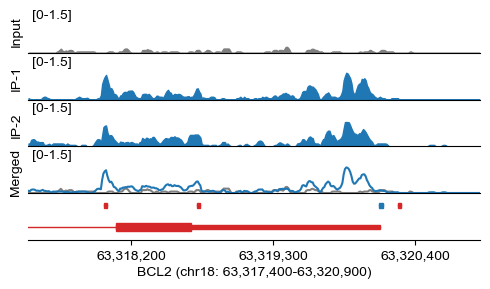

In [6]:
def smooth(xs, ys, step=10):
    assert len(xs) % step == 0
    xs1, ys1 = [], []
    for i in range(0, len(xs), step):
        xs1.append(np.mean(xs[i:i+step]))
        ys1.append(np.mean(ys[i:i+step]))
    return np.array(xs1), np.array(ys1)


def plot_bwfile(ax, path, chrom, start, end, ylim=None, color="C0", ylabel=None, spans=[]):
    ax0 = plt.gca()
    plt.sca(ax)
    
    with pyBigWig.open(path) as f:
        ys = np.nan_to_num(f.values(chrom, start, end), 0)
    xs = np.arange(start, end)
    xs, ys = smooth(xs, ys, 10)
    plt.fill_between(xs, 0, ys, color=color)
    plt.xlim(start, end)
    if ylim is None:
        ylim = ax.get_ylim()[1]
    plt.ylim(0, ylim)
    if ylabel:
        plt.ylabel(ylabel)
    plt.text(start + (end - start) * 0.01, ylim * 0.8, "[0-%.1f]" % ylim)
    for span in spans:
        plt.axvspan(span[0], span[1], color="C3", alpha=0.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.sca(ax0)
    return xs, ys

def plot_genomic_regions(ax, regions, chrom, start, end):
    ax0 = plt.gca()
    plt.sca(ax)

    last_region = None
    top = 0
    for region in regions:
        if last_region is not None and region.start < last_region.end:
            top -= 1
        last_region = region
        mid = top - 0.4
        color = "C0" if region.strand == "+" else "C3"
        x1, x2 = max(region.start, start), min(region.end, end)
        if x1 < x2:
            plt.plot([x1, x2], [mid, mid], lw=1, color=color)
        h1 = 0.1 # for exon
        h2 = 0.2 # for CDS
        
        for exon in region.blocks:
            x1, x2 = max(exon[0], start), min(exon[1], end)
            if x1 < x2:
                x = (x1 + x2) / 2
                plt.bar(x, h1 * 2, bottom=mid-h1, width=x2-x1, color=color, edgecolor=color, lw=1)
                if region.thick:
                    x3, x4 = max(x1, region.thick[0]), min(x2, region.thick[1])
                    if x3 < x4:
                        x = (x3 + x4) / 2
                        plt.bar(x, h2 * 2, bottom=mid-h2, width=x4-x3, color=color, edgecolor=color, lw=1)
                

    plt.xlim(start, end)
    plt.ylim(top - 1, 0)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.sca(ax0)

bwfiles = [
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_RBM12_CLIP_Input_Rep2_norm_neg.bw", 1.5, "C7", "Input"],
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_RBM12_CLIP_IP_Rep1_norm_neg.bw", 1.5, "C0", "IP-1"],
    ["../../2_seCLIPseq/results/3_tracks/1_bw/20241028_293T_RBM12_CLIP_IP_Rep2_norm_neg.bw", 1.5, "C0", "IP-2"], 
]

array = []

chrom, start, end = "chr18", 63317400, 63320900

regions = []
with BedFile("results/g4.bed.gz", random=True) as f:
    for r in f.fetch(chrom, start, end):
        regions.append(r)
regions.append(transcripts["ENST00000398117.1"])

fig, axs = plt.subplots(len(bwfiles) + 2, 1, figsize=(5, 3), sharex=False)
if True:
    for i, item in enumerate(bwfiles):
        xs, ys = plot_bwfile(axs[i], item[0], chrom, start, end, ylim=item[1], color=item[2], ylabel=item[3])
        array.append([xs, ys])

if True:
    plt.sca(axs[-2])
    xs = array[0][0]
    ys1 = array[0][1]
    ys2 = (array[1][1] + array[2][1]) / 2
    plt.plot(xs, ys1, color="C7")
    plt.plot(xs, ys2, color="C0")
    plt.xlim(start, end)
    ylim = 1.5
    plt.ylim(0, ylim)
    # plt.axvspan(rg4.start, rg4.end, color="C3", alpha=0.2)
    plt.ylabel("Merged")
    plt.text(start + (end - start) * 0.01, ylim * 0.8, "[0-1.5]")
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xticks([])
    plt.yticks([])

if True:
    plot_genomic_regions(axs[-1], regions, chrom, start, end)

# xticks
if True:
    plt.sca(axs[-1])
    gap = int(int((end-start)/3)/100) * 100
    xs = []
    for x in np.arange(int(start/gap) * gap, end, gap):
        if x >= start:
            xs.append(x)
    plt.xticks(xs, [format(x, ",") for x in xs])
    plt.xlabel("BCL2 (%s: %s-%s)" % (chrom, format(start, ","), format(end, ",")))

plt.tight_layout(h_pad=0.2)
plt.savefig("figures/seCLIPseq_tracks.BCL2.pdf")